In [481]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, auc, RocCurveDisplay
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN



In [482]:
data = pd.read_csv('../data/processed/data.csv')
data = data.drop(columns='session_id')
# data = data.drop(columns=['Unnamed: 0', 'url', 'referrer', 'session_id'])

In [483]:
X = data[[column for column in list(data.columns) if column not in ['label', 'session_id', 'new_label','acceleration_pos_neg_ratio','acceleration_std','clicks_count', 'time_morning','durations','hover_frequency','speed_cv']]]
y = data[['new_label']]
#y = data[['label']]

In [484]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Define function to add Gaussian noise

In [485]:
def add_gaussian_noise(X, noise_level=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    return X + noise

In [486]:
len([i for i in y['new_label'] if i == 'human'])

109

#### Testing oversampling techniques

#### 1. SMOTE

#### With CV

In [487]:

# Define KNN model with preprocessing pipeline
# StandardScaler is usually helpful for KNN
knn_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('smote', SMOTE(sampling_strategy={'human': 340}, random_state=42)), 
                     ('knn', KNeighborsClassifier())])

# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"CV Fold Accuracies (on training): {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit model on full training set
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
y_prob = knn_pipe.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(knn_pipe.named_steps['knn'].classes_)


CV Fold Accuracies (on training): [0.98148148 1.         0.96296296 0.96296296 0.98113208]
Mean CV Accuracy: 0.9777 ± 0.0138
Test set accuracy: 0.9667
ROC AUC: 0.9938
['bot' 'human']


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

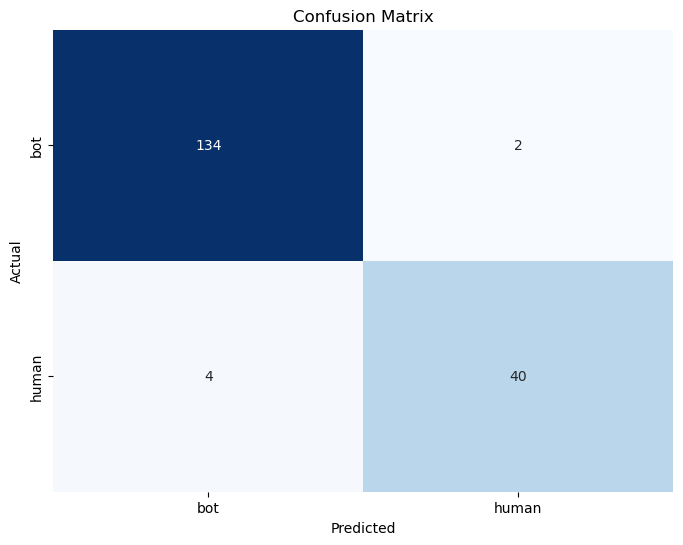

In [488]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [489]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9667


#### 2. Borderline SMOTE

#### With CV

In [490]:
# Define KNN model with preprocessing pipeline
# StandardScaler is usually helpful for KNN

knn_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('borderline_smote', BorderlineSMOTE(random_state=42)), 
                     ('knn', KNeighborsClassifier())])

# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"CV Fold Accuracies (on training): {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit model on full training set
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
y_prob = knn_pipe.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(knn_pipe.named_steps['knn'].classes_)



CV Fold Accuracies (on training): [0.98148148 1.         0.94444444 0.94444444 0.98113208]
Mean CV Accuracy: 0.9703 ± 0.0222
Test set accuracy: 0.9778
ROC AUC: 0.9876
['bot' 'human']


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

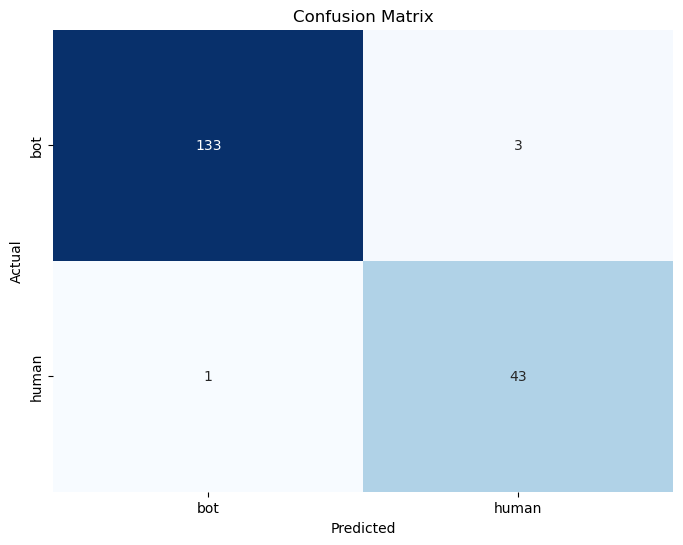

In [491]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### 3. ADASYN

#### With CV

In [492]:

# Define KNN model with preprocessing pipeline
# StandardScaler is usually helpful for KNN
knn_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('adasyn', ADASYN(sampling_strategy='minority',random_state=42)), 
                     ('knn', KNeighborsClassifier())])

# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(knn_pipe, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"CV Fold Accuracies (on training): {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit model on full training set
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
y_prob = knn_pipe.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(knn_pipe.named_steps['knn'].classes_)


CV Fold Accuracies (on training): [0.98148148 1.         0.96296296 0.98148148 0.98113208]
Mean CV Accuracy: 0.9814 ± 0.0117
Test set accuracy: 0.9722
ROC AUC: 0.9841
['bot' 'human']


/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/linyan/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected

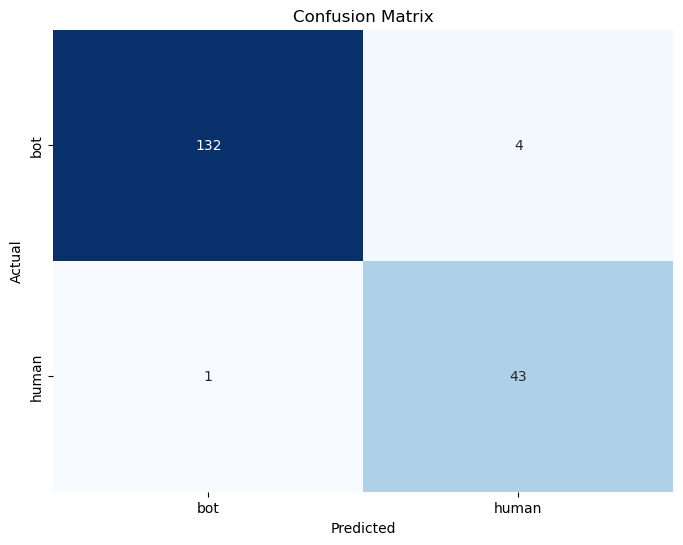

In [493]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()